# Clustering of Wholesale Customers

In [1]:
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.metrics.cluster import rand_score,  homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler



# Describe the dataset
This dataset shows us the clients of a whole sale distributor. the feature  shows us how much money the clients spend on each category, these include fresh foods, milk, grocery and so on. This dataset also has a target which is region. the purpose of the dataset is to cluster the shopping habits of the clients

In [2]:
wholesale_data = pd.read_csv('data/Wholesale customers data.csv').astype('category')
wholesale_data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


# preprosessing of data
just making sure all the columns are numerical

In [3]:
wholesale_data = wholesale_data.apply(pd.to_numeric, errors='coerce')

# Exploring the dataset
 using distribution, correlation and Principal Component Analysis

# Distribution analysis for the target
The target has three groups of values. one group is very big, whole the two others are much smaller. 
This could mean that 2-3 clusters could be the best, because there is one dominating label and two smaller. this depends if it is better for the two smaller labels to be represented in their own cluster, but we will also see with later testing if this is the case

<Axes: xlabel='Region'>

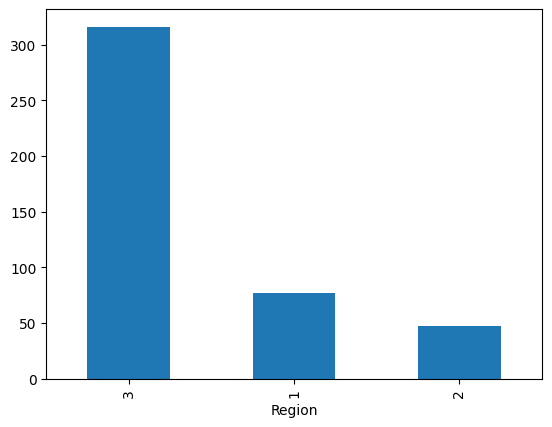

In [4]:
target = wholesale_data['Region']
target.value_counts().plot.bar()

# distribtution analysis for the features
from the hist function we can see that most of the features are normally distributed to the left.  
the models we will use to test:   
Kmeans  
AgglomerativeClustering  
DBSCAN  


In [5]:
wholesale_unlabeled = wholesale_data.drop('Region', axis=1)

(440, 7)

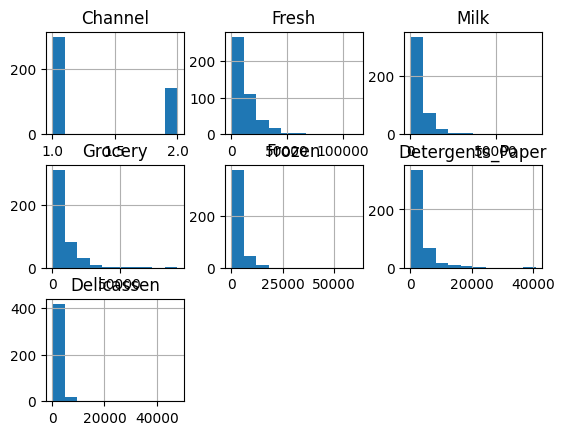

In [6]:
wholesale_unlabeled = wholesale_data.drop('Region', axis=1)
wholesale_unlabeled.hist()
wholesale_unlabeled.shape

# corrolation analysis of the features
from the correlation table under we can se that there are 5 high correlations between the features.  

detergent_paper and grocery has very high correlation at 0.925  
detergent_paper also has high correlation with channel and milk with above 0.6  

grocery has high correlation with channel and milk with correlation of 0.61 and 0.723  


In [7]:
feature_correlation = wholesale_unlabeled.corr()
feature_correlation.style.background_gradient(cmap='coolwarm')

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Channel,1.000000,-0.169172,0.460720,0.608792,-0.202046,0.636026,0.056011
Fresh,-0.169172,1.000000,0.100510,-0.011854,0.345881,-0.101953,0.244690
Milk,0.460720,0.100510,1.000000,0.728335,0.123994,0.661816,0.406368
Grocery,0.608792,-0.011854,0.728335,1.000000,-0.040193,0.924641,0.205497
Frozen,-0.202046,0.345881,0.123994,-0.040193,1.000000,-0.131525,0.390947
Detergents_Paper,0.636026,-0.101953,0.661816,0.924641,-0.131525,1.000000,0.069291
Delicassen,0.056011,0.244690,0.406368,0.205497,0.390947,0.069291,1.000000


# Preprocessing of data after looking at correlation
removing the columns Detergents_Paper and Grocery removed all the high correlation from the dataset, and made the dimentionality lower

In [8]:

wholesale_unlabeled= wholesale_unlabeled.drop('Detergents_Paper' , axis=1)
wholesale_unlabeled= wholesale_unlabeled.drop('Grocery' , axis=1)

feature_correlation = wholesale_unlabeled.corr()
feature_correlation.style.background_gradient(cmap='coolwarm')

,Channel,Fresh,Milk,Frozen,Delicassen
Channel,1.000000,-0.169172,0.460720,-0.202046,0.056011
Fresh,-0.169172,1.000000,0.100510,0.345881,0.244690
Milk,0.460720,0.100510,1.000000,0.123994,0.406368
Frozen,-0.202046,0.345881,0.123994,1.000000,0.390947
Delicassen,0.056011,0.244690,0.406368,0.390947,1.000000


# Principal Component Analysis
This is used to lower dimentionality further. By lowering the dimentionality we can imporove the performance of our clustering algortihm. dimentionality of 3 still kept a lot of explained variance

[0.66986083 0.89402906 0.97847815 1.         1.        ]


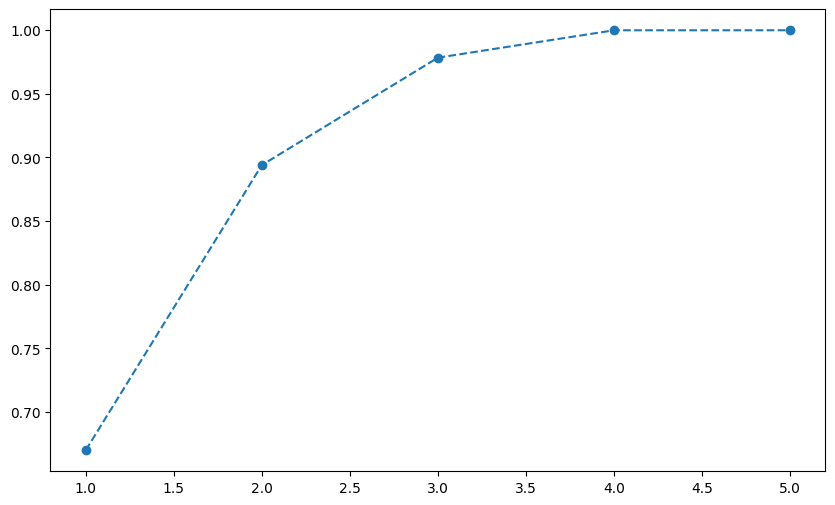

In [9]:
pca = PCA()
pca.fit(wholesale_unlabeled)
reduced_numerical_features_census_income = pca.transform(wholesale_unlabeled)
reduced_numerical_features_census_income.shape
explained_variance = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(explained_variance)
print(cumulative_variance)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.show()

# reducing the dimentionality of the data:

In [10]:

pca = PCA(3)
wholesale_unlabeled = pca.fit_transform(wholesale_unlabeled)

wholesale_unlabeled = pd.DataFrame(wholesale_unlabeled)
wholesale_unlabeled.head()



,0,1,2
0,572.031641,3412.863120,-3400.982363
1,-4656.271919,4429.976302,-1008.852690
2,-4949.476464,4577.970289,1108.036088
3,1333.093409,-4311.103668,3681.986214
4,10748.842973,-963.801427,28.750733


# normalizing the data
since the data is heavily right distirbuted, it could be good to help with the normalization

array([[<Axes: title={'center': 'Channel'}>,
        <Axes: title={'center': 'Region'}>,
        <Axes: title={'center': 'Fresh'}>],
       [<Axes: title={'center': 'Milk'}>,
        <Axes: title={'center': 'Grocery'}>,
        <Axes: title={'center': 'Frozen'}>],
       [<Axes: title={'center': 'Detergents_Paper'}>,
        <Axes: title={'center': 'Delicassen'}>, <Axes: >]], dtype=object)

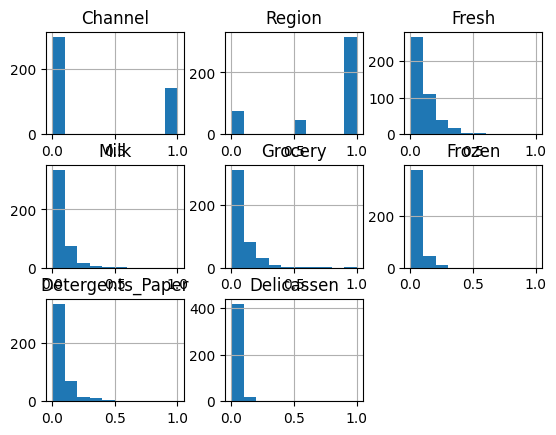

In [11]:
wholesale_unlabeled = pd.DataFrame(MinMaxScaler().fit_transform(wholesale_data), columns=wholesale_data.columns)
wholesale_unlabeled.hist()

# making the models and hyperparameter tuning
in this assignment i have to find the best model for this clustering problem. I am going to test different types of model, and see what kind of parameters give the best result. I am going to use the grid search algorithm to find the best parameter combination and testing a range og values for each parameter.  

# K-means model:

first finding the best number of clusters using the elbow method

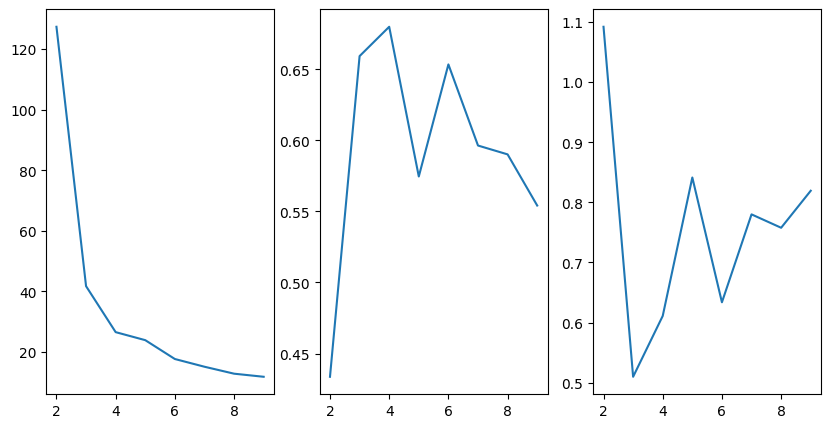

In [12]:
scores_inertia = []
scores_silhouette = []
scores_davies = []
n_clusters = range(2,10)
for i in n_clusters:
    km = KMeans(n_clusters=i).fit(wholesale_unlabeled)
    scores_inertia.append(km.inertia_)
    scores_silhouette.append(silhouette_score(wholesale_unlabeled, km.labels_))
    scores_davies.append(davies_bouldin_score(wholesale_unlabeled, km.labels_))

fig, ax = plt.subplots(1, 3, figsize=(10,5))
ax[0].plot(n_clusters, scores_inertia)
ax[1].plot(n_clusters, scores_silhouette)
ax[2].plot(n_clusters, scores_davies)
plt.show()

# confirming this by looking at the clusters

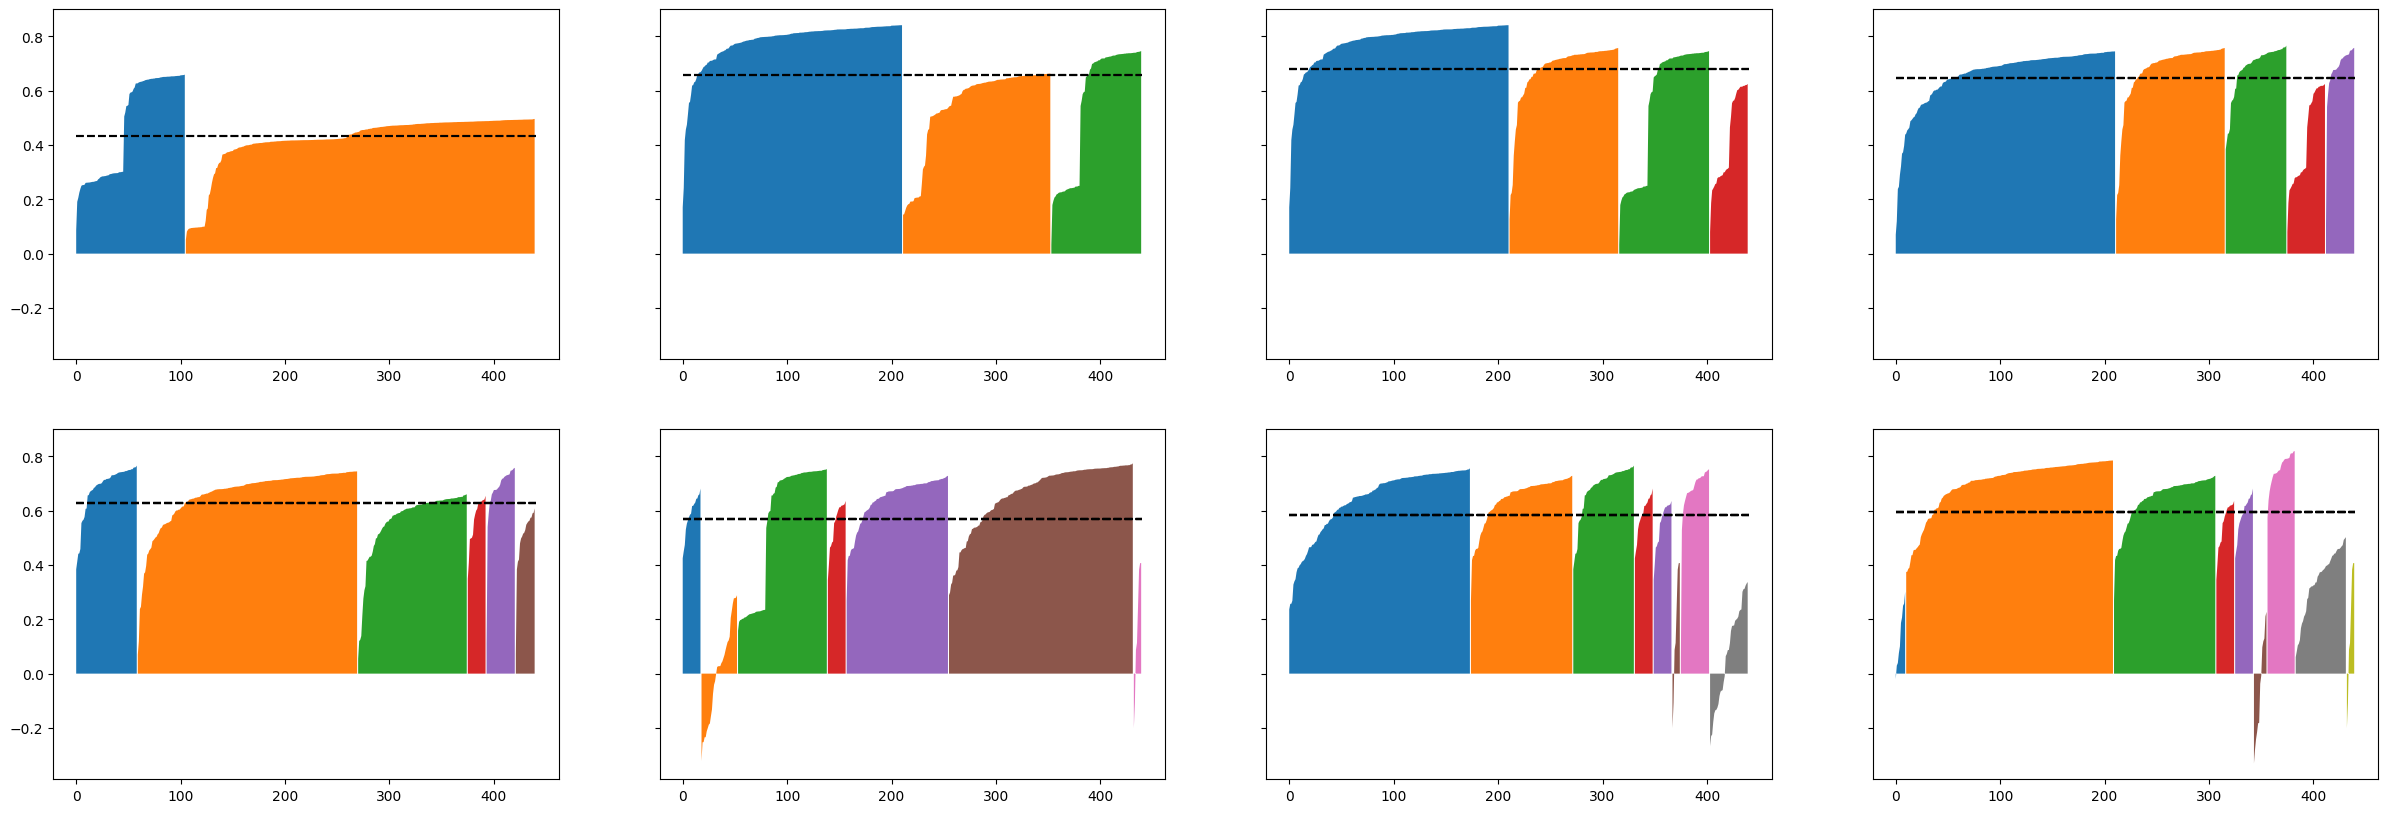

In [13]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(30,10))
for i in n_clusters:
    km = KMeans(n_clusters=i).fit(wholesale_unlabeled)
    silhouette_average = silhouette_score(wholesale_unlabeled, km.labels_)
    sample_silhouette = silhouette_samples(wholesale_unlabeled, km.labels_)
    x_start = 0
    for cluster_i in range(i):
        ith_cluster_samples = sample_silhouette[km.labels_ == cluster_i]
        ith_cluster_samples.sort()
        x_end = x_start + ith_cluster_samples.shape[0]
        ax[(i-2)//4][(i-2)%4].fill_between(np.arange(x_start, x_end), 0, ith_cluster_samples)
        ax[(i-2)//4][(i-2)%4].plot([0,sample_silhouette.shape[0]],[silhouette_average, silhouette_average], '--', color='black')
        x_start = x_end 

the best number of clusters is 3 accordin to the elbow technique, and it has the very good silhouette and davies score

the grid search algortihm needs custom scores for clustering, because it don't include silhouette and david

In [14]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

def david_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return  -davies_bouldin_score(X, labels)


scoring = {
    'silhouette': silhouette_scorer,
    'davies': david_scorer,

}

# Tuning the other parameters:  
i tried a to test a wide range of parameters, but not too wide so i don't get a too high run time

In [15]:
dt_params = {
    'n_init': range(1,16, 3),
    'max_iter': range(260,330, 10)
}

kmeans = KMeans(n_clusters=3)
km_grid = GridSearchCV(kmeans, dt_params, scoring=scoring, refit='silhouette')
km_grid.fit(wholesale_unlabeled)
km_cv_result = pd.DataFrame(km_grid.cv_results_)
km_cv_result


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,param_n_init,params,split0_test_silhouette,split1_test_silhouette,split2_test_silhouette,...,std_test_silhouette,rank_test_silhouette,split0_test_davies,split1_test_davies,split2_test_davies,split3_test_davies,split4_test_davies,mean_test_davies,std_test_davies,rank_test_davies
0,0.001277,0.002553,0.014512,0.003259,260,1,"{'max_iter': 260, 'n_init': 1}",0.763044,0.736808,0.738430,...,0.111457,21,-0.508543,-0.313058,-0.470148,-0.594502,-0.303386,-0.437928,0.113344,1
1,0.012649,0.003598,0.024373,0.001256,260,4,"{'max_iter': 260, 'n_init': 4}",0.763044,0.674592,0.742075,...,0.104525,30,-0.508543,-0.640540,-0.470148,-0.594502,-0.866541,-0.616055,0.139036,20
2,0.019701,0.003359,0.040021,0.004439,260,7,"{'max_iter': 260, 'n_init': 7}",0.763044,0.752031,0.742075,...,0.112531,2,-0.508543,-0.745034,-0.470148,-0.594502,-0.866541,-0.636954,0.148665,21
3,0.024276,0.000265,0.054956,0.003152,260,10,"{'max_iter': 260, 'n_init': 10}",0.763044,0.752031,0.742075,...,0.112531,2,-0.508543,-0.612128,-0.470148,-0.594502,-0.866541,-0.610373,0.138498,4
4,0.038274,0.005165,0.072422,0.007462,260,13,"{'max_iter': 260, 'n_init': 13}",0.763044,0.752031,0.742075,...,0.112531,2,-0.508543,-0.612128,-0.470148,-0.594502,-0.866541,-0.610373,0.138498,4
5,0.000000,0.000000,0.016180,0.000151,270,1,"{'max_iter': 270, 'n_init': 1}",0.763044,0.725675,0.742075,...,0.108887,23,-0.508543,-0.783698,-0.470148,-0.594502,-0.866541,-0.644686,0.154958,26
6,0.011987,0.003719,0.024502,0.000990,270,4,"{'max_iter': 270, 'n_init': 4}",0.763044,0.674592,0.742075,...,0.104525,30,-0.508543,-0.783698,-0.470148,-0.594502,-0.866541,-0.644686,0.154958,26
7,0.019405,0.004010,0.038844,0.003223,270,7,"{'max_iter': 270, 'n_init': 7}",0.763044,0.752031,0.742075,...,0.112531,2,-0.508543,-0.612128,-0.470148,-0.594502,-0.866541,-0.610373,0.138498,4
8,0.028671,0.004220,0.052026,0.003568,270,10,"{'max_iter': 270, 'n_init': 10}",0.763044,0.752031,0.742075,...,0.112531,2,-0.508543,-0.612128,-0.470148,-0.594502,-0.866541,-0.610373,0.138498,4
9,0.033997,0.003186,0.064613,0.005327,270,13,"{'max_iter': 270, 'n_init': 13}",0.763044,0.752031,0.742075,...,0.112531,2,-0.508543,-0.783698,-0.470148,-0.594502,-0.866541,-0.644686,0.154958,26


# AgglomerativeClustering model

finding the best number of clusters looking at the davies and silhouette score

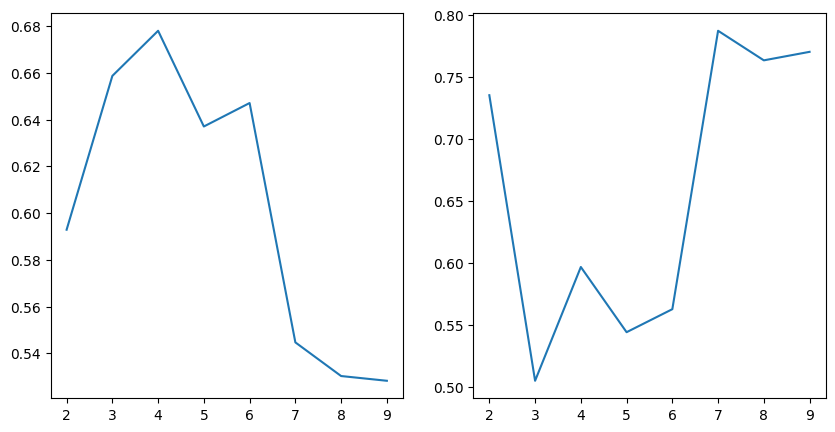

In [16]:
scores_silhouette = []
scores_davies = []
n_clusters = range(2,10)
for i in n_clusters:
    ac = AgglomerativeClustering(n_clusters=i).fit(wholesale_unlabeled)
    scores_silhouette.append(silhouette_score(wholesale_unlabeled, ac.labels_))
    scores_davies.append(davies_bouldin_score(wholesale_unlabeled, ac.labels_))

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(n_clusters, scores_silhouette)
ax[1].plot(n_clusters, scores_davies)
plt.show()

looking at the number of clusters looking and the silhouette score

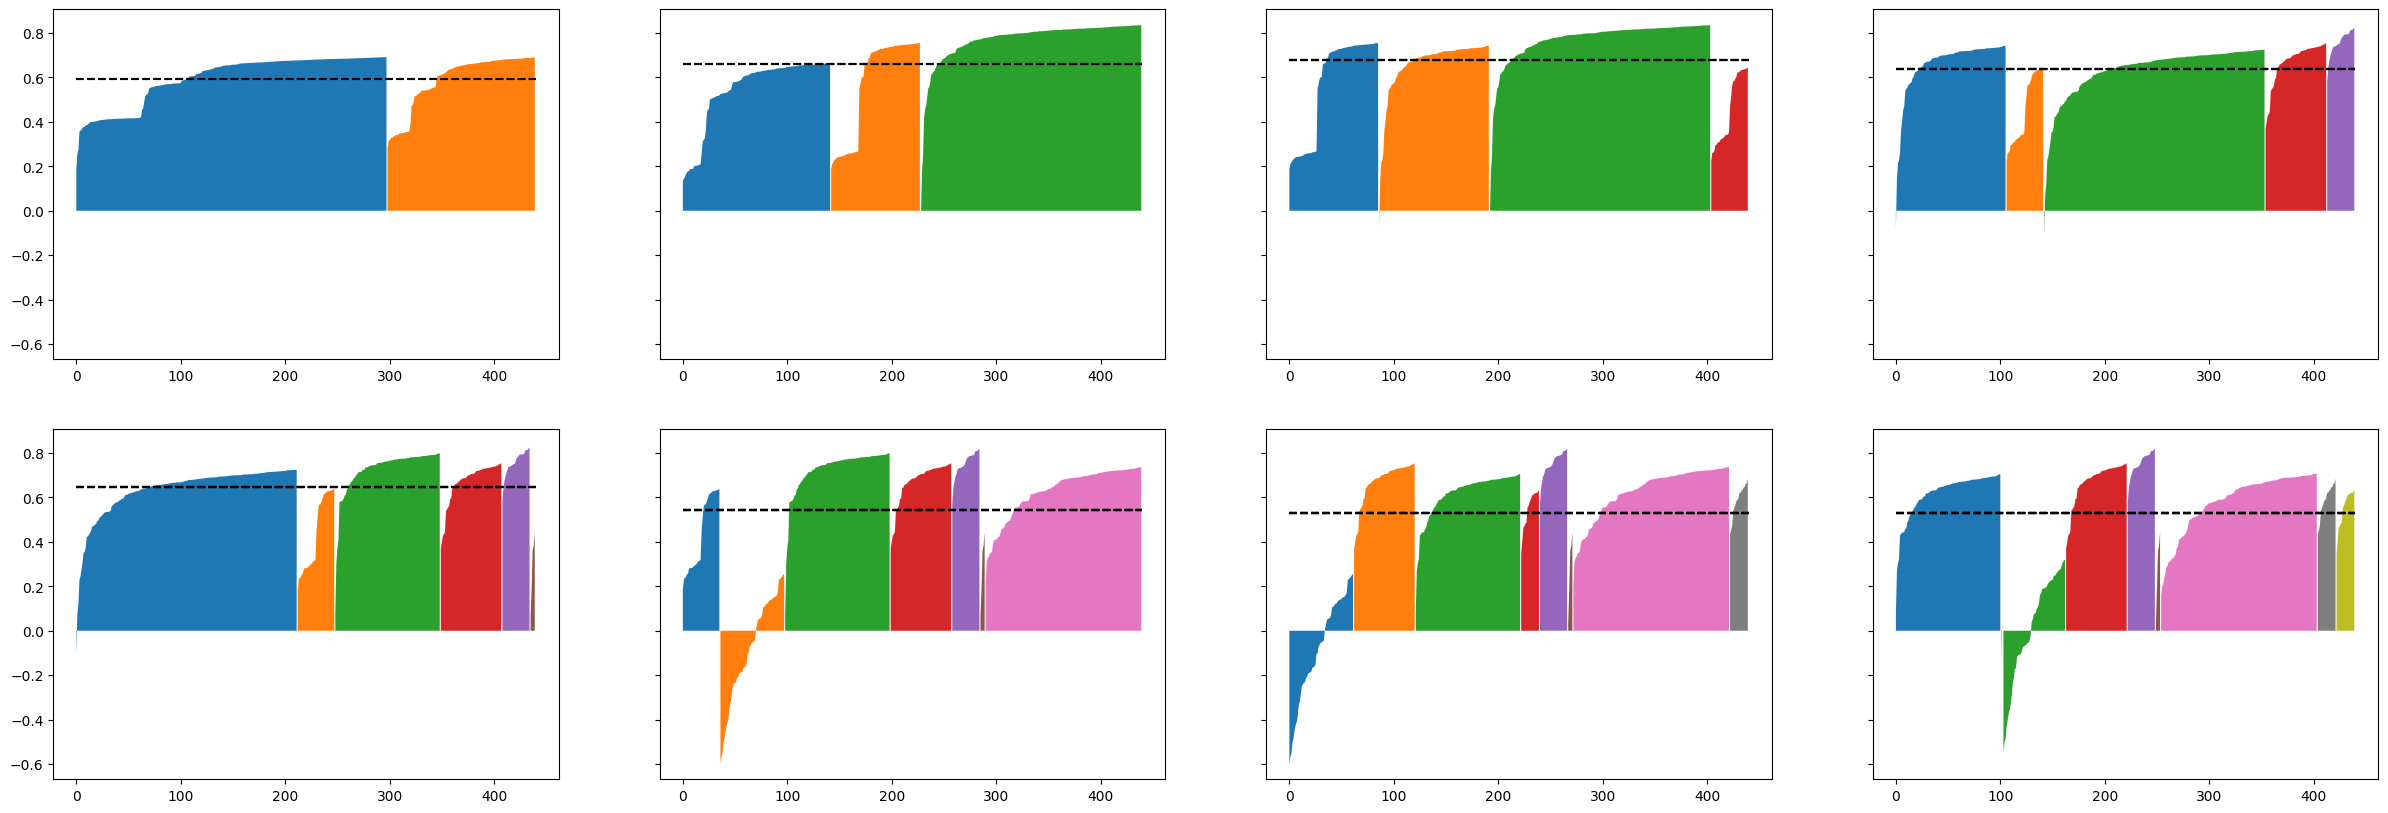

In [17]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(30,10))
for i in n_clusters:
    ac = AgglomerativeClustering(n_clusters=i).fit(wholesale_unlabeled)
    silhouette_average = silhouette_score(wholesale_unlabeled, ac.labels_)
    sample_silhouette = silhouette_samples(wholesale_unlabeled, ac.labels_)
    x_start = 0
    for cluster_i in range(i):
        ith_cluster_samples = sample_silhouette[ac.labels_ == cluster_i]
        ith_cluster_samples.sort()
        x_end = x_start + ith_cluster_samples.shape[0]
        ax[(i-2)//4][(i-2)%4].fill_between(np.arange(x_start, x_end), 0, ith_cluster_samples)
        ax[(i-2)//4][(i-2)%4].plot([0,sample_silhouette.shape[0]],[silhouette_average, silhouette_average], '--', color='black')
        x_start = x_end 

the best number of clusters is clearly 3 as it has the best scores

finding the other parameters  
not all combinations of paramteres will work, because ward can only be used with euclidean, but it wont be a problem

In [18]:
ac_params = {
    'linkage': ['ward', 'complete', 'average', 'single'],
    'metric': ['euclidean', 'manhattan', 'cosine']
    
}

agglomerative = AgglomerativeClustering(n_clusters=3)
ac_grid = GridSearchCV(agglomerative, ac_params, scoring=scoring, refit='silhouette')
ac_grid.fit(wholesale_unlabeled)
ac_cv_result = pd.DataFrame(ac_grid.cv_results_)
ac_cv_result

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 886, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_linkage,param_metric,params,split0_test_silhouette,split1_test_silhouette,split2_test_silhouette,...,std_test_silhouette,rank_test_silhouette,split0_test_davies,split1_test_davies,split2_test_davies,split3_test_davies,split4_test_davies,mean_test_davies,std_test_davies,rank_test_davies
0,0.000904,0.001807,0.007250,0.001885,ward,euclidean,"{'linkage': 'ward', 'metric': 'euclidean'}",0.766864,0.674592,0.742075,...,0.106485,5,-0.455296,-0.783698,-0.470148,-0.594502,-0.858794,-0.632487,0.163262,8
1,0.001595,0.003190,0.000000,0.000000,ward,manhattan,"{'linkage': 'ward', 'metric': 'manhattan'}",NaN,NaN,NaN,...,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
2,0.000000,0.000000,0.000000,0.000000,ward,cosine,"{'linkage': 'ward', 'metric': 'cosine'}",NaN,NaN,NaN,...,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
3,0.003203,0.003923,0.003302,0.004047,complete,euclidean,"{'linkage': 'complete', 'metric': 'euclidean'}",0.736075,0.748974,0.588105,...,0.080675,3,-0.604018,-0.313058,-0.807507,-0.519093,-0.303386,-0.509412,0.189159,5
4,0.000000,0.000000,0.008057,0.000117,complete,manhattan,"{'linkage': 'complete', 'metric': 'manhattan'}",0.766864,0.733666,0.588105,...,0.083504,2,-0.455296,-0.742601,-0.807507,-0.524560,-0.303386,-0.566670,0.185715,7
5,0.003202,0.003922,0.003201,0.003921,complete,cosine,"{'linkage': 'complete', 'metric': 'cosine'}",0.728762,0.752031,0.738430,...,0.113716,7,-0.660252,-0.612128,-0.493524,-0.788794,-0.872529,-0.685446,0.133060,9
6,0.004817,0.003933,0.003307,0.004053,average,euclidean,"{'linkage': 'average', 'metric': 'euclidean'}",0.763044,0.748974,0.579043,...,0.086953,1,-0.508543,-0.313058,-0.732383,-0.524560,-0.303386,-0.476386,0.158426,4
7,0.003195,0.003913,0.004842,0.003954,average,manhattan,"{'linkage': 'average', 'metric': 'manhattan'}",0.766864,0.748974,0.466339,...,0.121019,4,-0.455296,-0.313058,-0.397013,-0.524560,-0.303386,-0.398663,0.084221,3
8,0.001600,0.003200,0.006310,0.003161,average,cosine,"{'linkage': 'average', 'metric': 'cosine'}",0.763044,0.732083,0.738430,...,0.232441,9,-0.508543,-0.227644,-0.493524,-1.632068,-0.846221,-0.741600,0.486598,10
9,0.006486,0.003275,0.001678,0.003355,single,euclidean,"{'linkage': 'single', 'metric': 'euclidean'}",0.730092,0.732083,0.434284,...,0.124095,6,-0.287415,-0.227644,-0.453982,-0.524560,-0.303386,-0.359397,0.111268,1


# dbscan
this model does not require number of cluster as an input, but has other parameters to tune. i tried to fint the most important parameters and testing with a good range.  
not all of the models work, because it didnt form enough clusters and only looked at the whole dataset as noise, but one good one is possible to find.  

In [19]:
dbscan_params = {
    'eps': np.arange(0.1, 1.5, 0.1),
    'min_samples': range(2, 10)  
}  


dbscan = DBSCAN()


dbscan_grid = GridSearchCV(dbscan, dbscan_params, scoring=scoring, refit='silhouette')


dbscan_grid.fit(wholesale_unlabeled)


dbscan_cv_result = pd.DataFrame(dbscan_grid.cv_results_)
dbscan_cv_result

c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_scorer.py", line 143, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
  File "C:\Users\Kosov\AppData\Local\Temp\ipykernel_20628\2248058682.py", line 3, in silhouette_scorer
    return silhouette_score(X, labels)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\Kosov\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\cluster\_unsupervised.py", line 141, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=me

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eps,param_min_samples,params,split0_test_silhouette,split1_test_silhouette,split2_test_silhouette,...,std_test_silhouette,rank_test_silhouette,split0_test_davies,split1_test_davies,split2_test_davies,split3_test_davies,split4_test_davies,mean_test_davies,std_test_davies,rank_test_davies
0,0.004296,0.003636,0.005506,0.003567,0.1,2,"{'eps': 0.1, 'min_samples': 2}",0.238918,0.662185,0.320002,...,0.143054,80,-1.462613,-1.298925,-1.172700,-1.200617,-1.308894,-1.288750,0.101954,74
1,0.001602,0.003204,0.006530,0.003269,0.1,3,"{'eps': 0.1, 'min_samples': 3}",0.532582,0.662185,0.324529,...,0.138649,76,-1.445054,-1.298925,-1.180307,-1.346231,-1.348458,-1.323795,0.086050,77
2,0.001626,0.003252,0.008111,0.000202,0.1,4,"{'eps': 0.1, 'min_samples': 4}",0.532582,0.662185,0.380134,...,0.148447,75,-1.445054,-1.298925,-1.227698,-1.452948,-1.361319,-1.357189,0.086104,78
3,0.003194,0.003912,0.004801,0.003920,0.1,5,"{'eps': 0.1, 'min_samples': 5}",0.512170,0.617938,0.465429,...,0.159440,77,-1.444463,-1.232549,-1.129661,-1.388986,-1.389720,-1.317076,0.117426,76
4,0.005703,0.003158,0.005742,0.004770,0.1,6,"{'eps': 0.1, 'min_samples': 6}",0.491657,0.571401,0.447752,...,0.073989,73,-1.445919,-1.283514,-1.144299,-1.001217,-1.330674,-1.241124,0.154070,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.012967,0.003942,0.018006,0.006065,1.4,5,"{'eps': 1.4000000000000001, 'min_samples': 5}",NaN,NaN,NaN,...,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
108,0.018153,0.005820,0.019300,0.003977,1.4,6,"{'eps': 1.4000000000000001, 'min_samples': 6}",NaN,NaN,NaN,...,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
109,0.012435,0.004457,0.021237,0.003940,1.4,7,"{'eps': 1.4000000000000001, 'min_samples': 7}",NaN,NaN,NaN,...,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81
110,0.015722,0.000727,0.016607,0.000709,1.4,8,"{'eps': 1.4000000000000001, 'min_samples': 8}",NaN,NaN,NaN,...,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81


# internal evaluation
including the silhouette socre and davies bouldin score:  
i retreieve the best models from each grid search and evaluate their results

In [20]:
km_best = km_grid.best_estimator_


print("internal evaluation")
km_labels = km_best.fit_predict(wholesale_unlabeled)
print("results from the best kmeans model")
print(f"silhouette score: {silhouette_score(wholesale_unlabeled, km_labels)}")
print(f"davies bouldin score: {davies_bouldin_score(wholesale_unlabeled, km_labels)}")
print()

ac_best = ac_grid.best_estimator_
ac_labels = ac_best.fit_predict(wholesale_unlabeled)

print("results from the best AgglomerativeClustering model")
print(f"silhouette score: {silhouette_score(wholesale_unlabeled, ac_labels)}")
print(f"davies bouldin score: {davies_bouldin_score(wholesale_unlabeled, ac_labels)}")
print()

dbscan_best = dbscan_grid.best_estimator_
debscan_labels = dbscan_best.fit_predict(wholesale_unlabeled)
print("results from the best DBSCAN model")
print(f"silhouette score: {silhouette_score(wholesale_unlabeled, debscan_labels)}")
print(f"davies bouldin score: {davies_bouldin_score(wholesale_unlabeled, debscan_labels)}")
print()

internal evaluation
results from the best kmeans model
silhouette score: 0.6593155081294824
davies bouldin score: 0.5097152869236671

results from the best AgglomerativeClustering model
silhouette score: 0.592315673591165
davies bouldin score: 0.5869947334892426

results from the best DBSCAN model
silhouette score: 0.6310674730355924
davies bouldin score: 1.1535755456096861



# vizulizing the clusters from the models

# kmeans

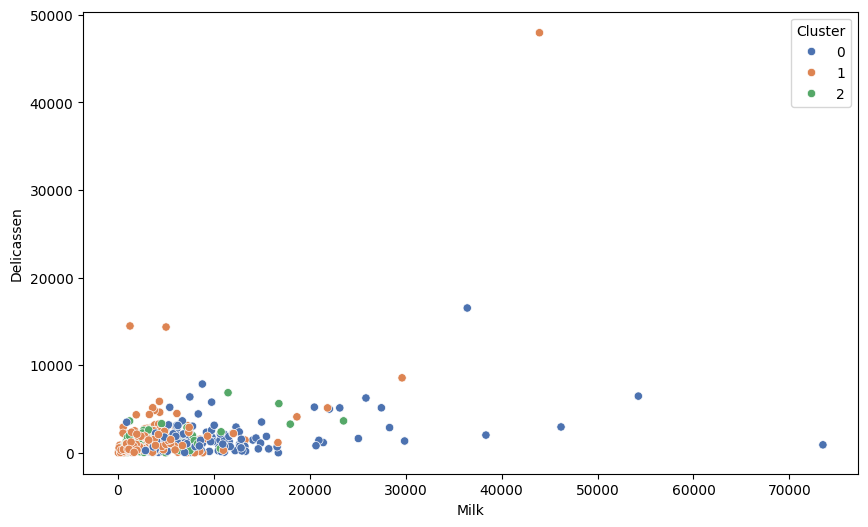

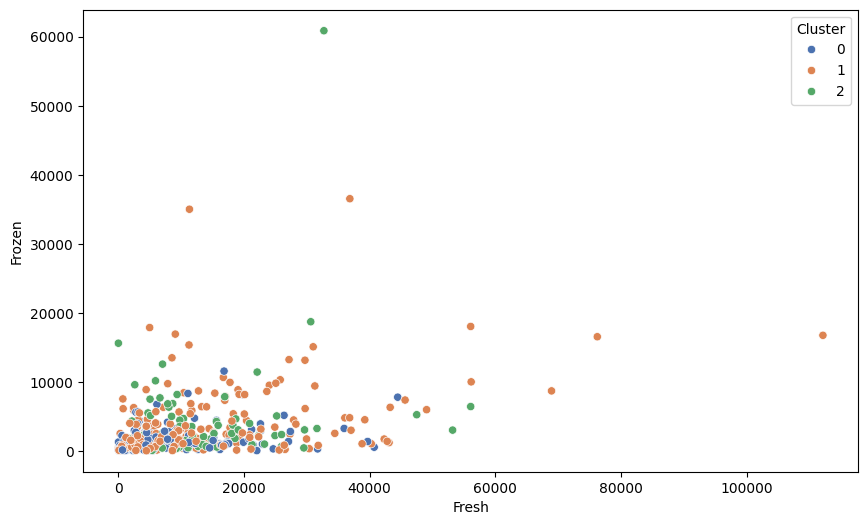

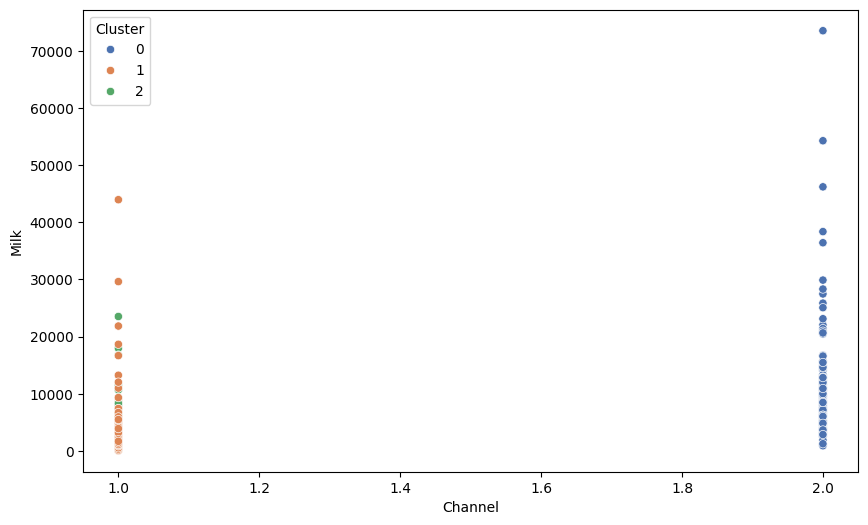

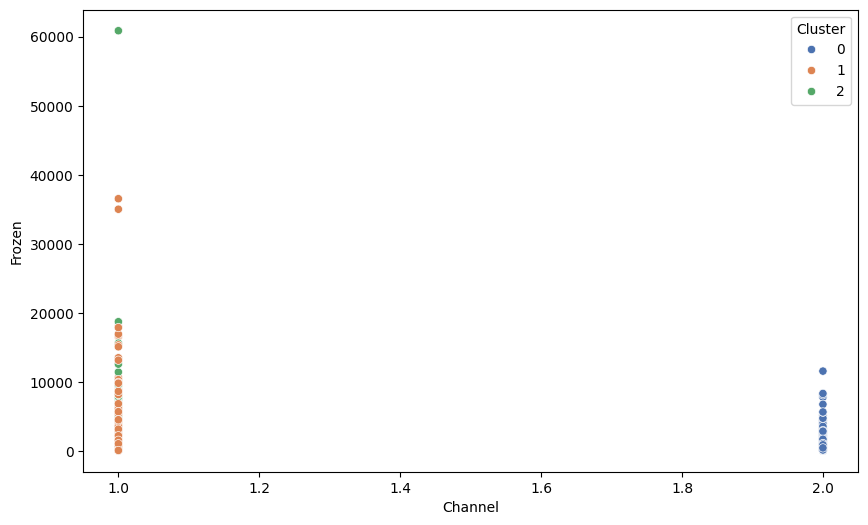

In [21]:
labels = km_best.predict(wholesale_unlabeled)

wholesale_data['Cluster'] = labels

feature_pairs = [
    ('Milk', 'Delicassen'),
    ('Fresh', 'Frozen'),
    ('Channel', 'Milk'),
    ('Channel', 'Frozen')
]

for x_feature, y_feature in feature_pairs:
    plt.figure(figsize=(10, 6))
    sb.scatterplot(data=wholesale_data, x=x_feature, y=y_feature, hue='Cluster', palette='deep')

the clusters aren't very clear in many of the scatterplots

# agglomerative

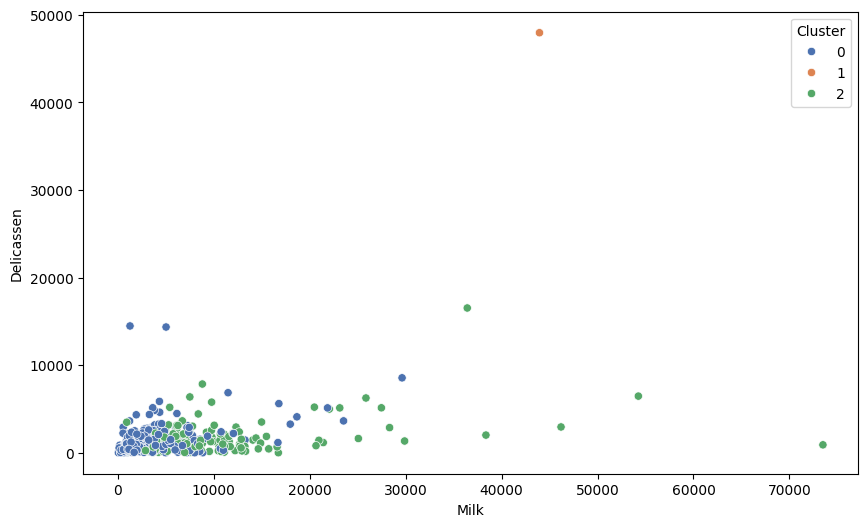

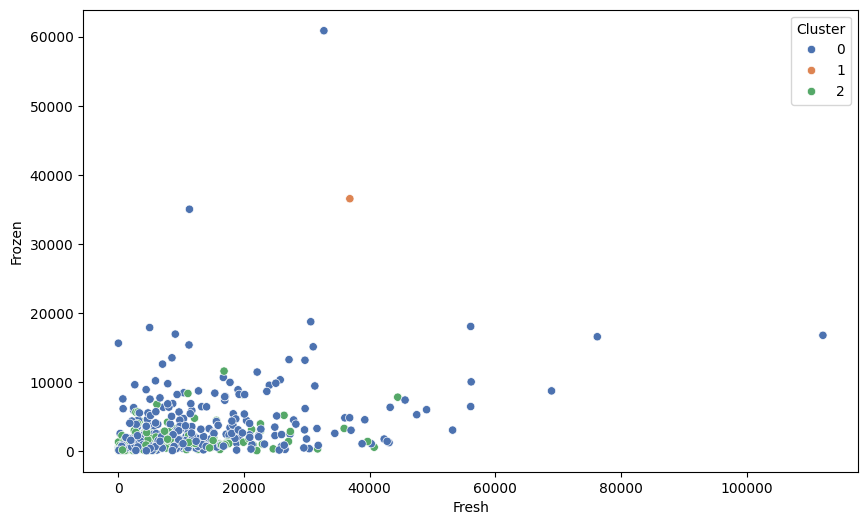

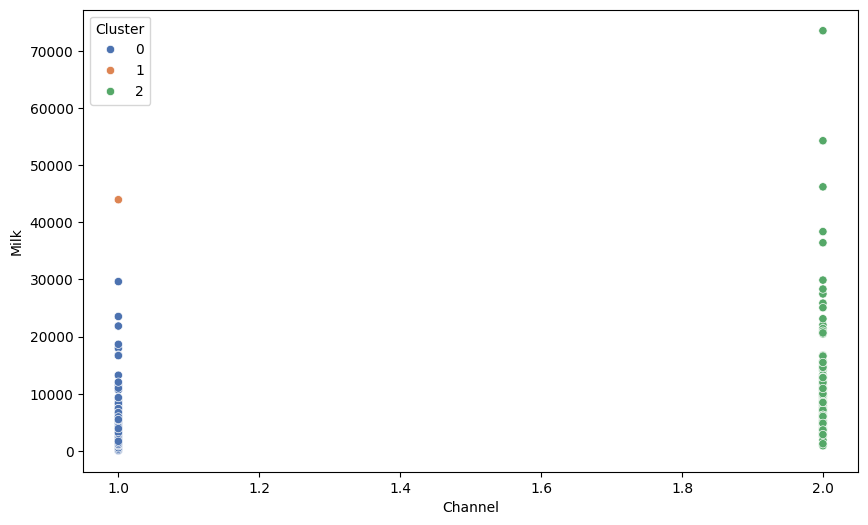

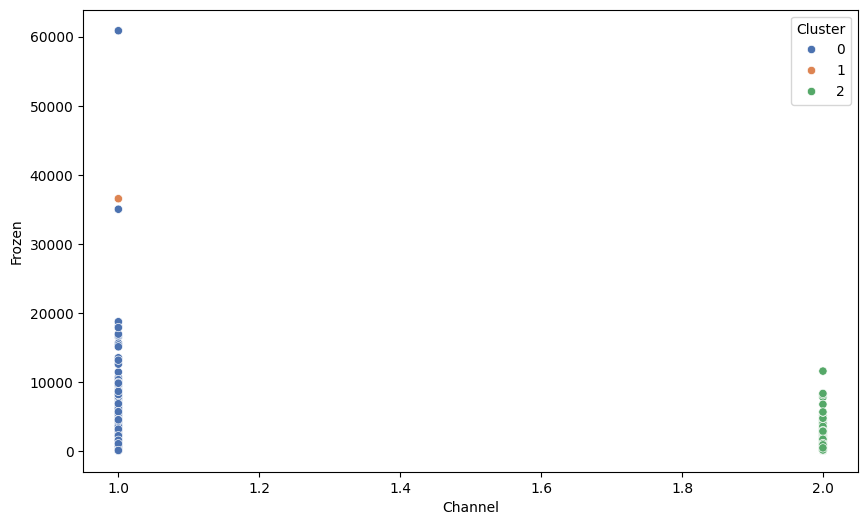

In [22]:
labels = ac_best.fit_predict(wholesale_unlabeled)

wholesale_data['Cluster'] = labels

feature_pairs = [
    ('Milk', 'Delicassen'),
    ('Fresh', 'Frozen'),
    ('Channel', 'Milk'),
    ('Channel', 'Frozen')
]

for x_feature, y_feature in feature_pairs:
    plt.figure(figsize=(10, 6))
    sb.scatterplot(data=wholesale_data, x=x_feature, y=y_feature, hue='Cluster', palette='deep')

the clusters are not as mixed here, but cluster one is very small with only one orange dot representing it

# dbscan

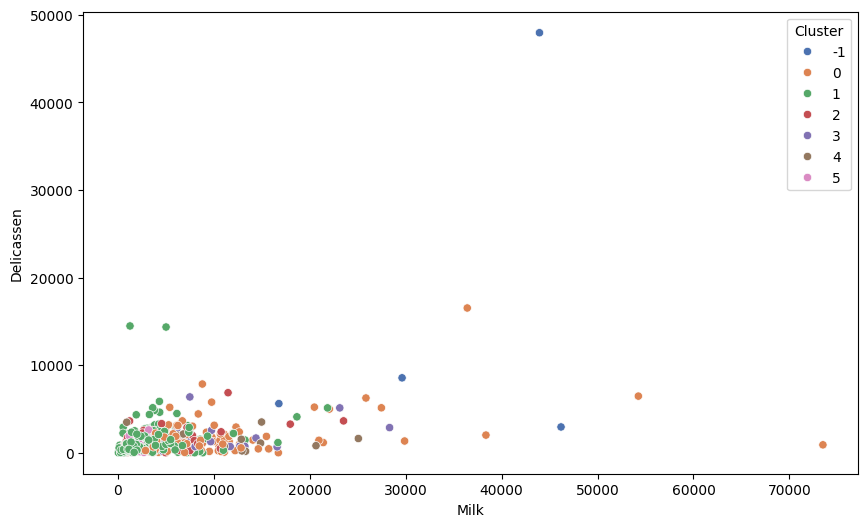

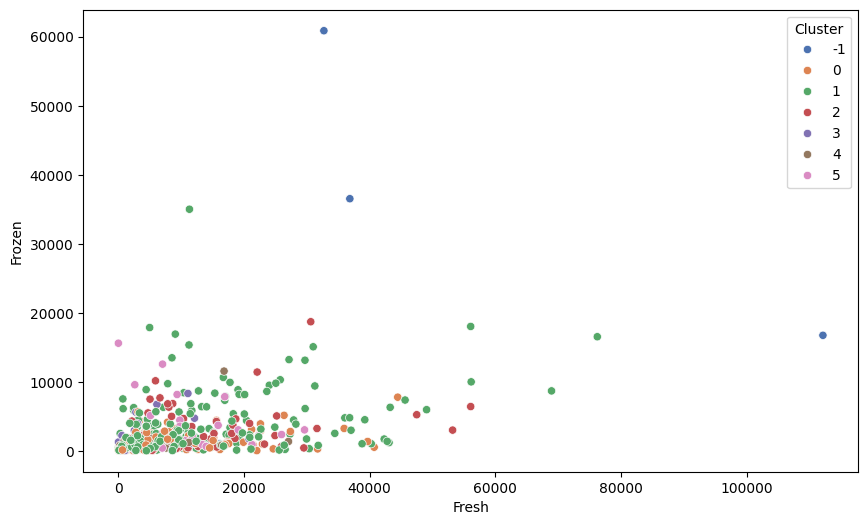

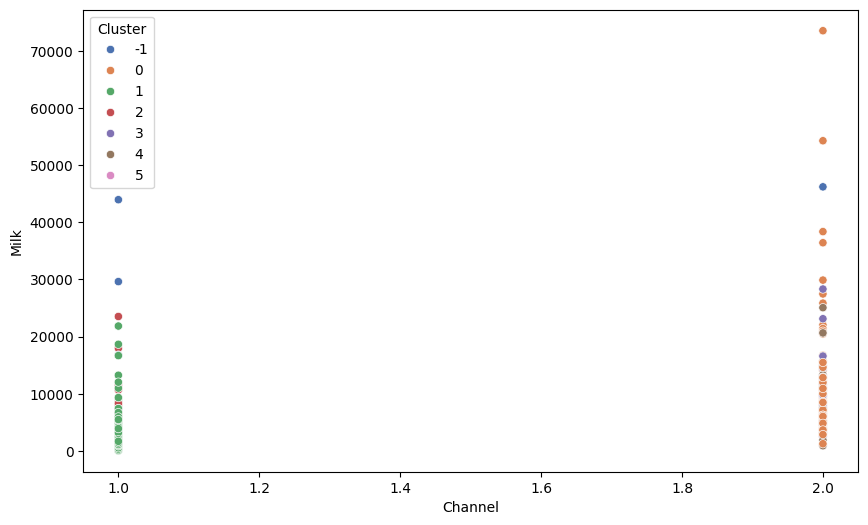

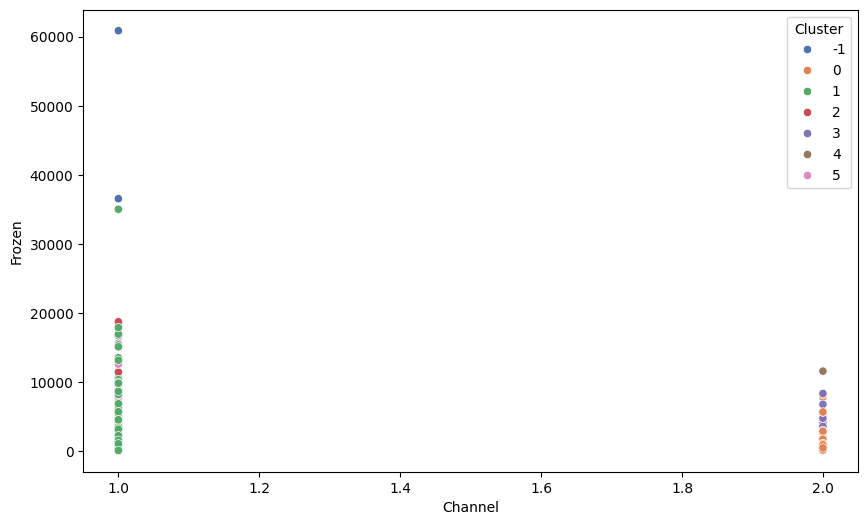

In [23]:
labels = dbscan_best.fit_predict(wholesale_unlabeled)

wholesale_data['Cluster'] = labels

feature_pairs = [
    ('Milk', 'Delicassen'),
    ('Fresh', 'Frozen'),
    ('Channel', 'Milk'),
    ('Channel', 'Frozen')
]

for x_feature, y_feature in feature_pairs:
    plt.figure(figsize=(10, 6))
    sb.scatterplot(data=wholesale_data, x=x_feature, y=y_feature, hue='Cluster', palette='deep')

the clusters are very mixed here also. there is a higher number of clusters then the other models.

# External evaluation
including the adjusted rand index, homogeneity, completeness, and the v-measure

In [24]:
def external_evaluation(model):
    predicted = model.fit_predict(wholesale_unlabeled)  

    print(f"rand score: {rand_score(target, predicted)}")
    print(f"homogenity score: {homogeneity_score(target, predicted)}")
    print(f"completeness score: {completeness_score(target, predicted)}")
    print(f"v_measure_score: {v_measure_score(target, predicted)}")
    print()

In [25]:
print("external evaluation: ")
print("kmeans model")
external_evaluation(km_best)

print("AgglomerativeClustering model")
external_evaluation(ac_best)


print("DBSCAN")
external_evaluation(dbscan_best)

external evaluation: 
kmeans model
rand score: 0.683267757299648
homogenity score: 0.5945885952412538
completeness score: 0.4678383819128164
v_measure_score: 0.5236526787876228

AgglomerativeClustering model
rand score: 0.5018844481259059
homogenity score: 0.00749087397521878
completeness score: 0.00909050046276313
v_measure_score: 0.008213528208161545

DBSCAN
rand score: 0.7481983847587492
homogenity score: 0.9902160443730786
completeness score: 0.5346879049450673
v_measure_score: 0.6944129726276562



the DEBSCAN had very good external evaluation scores, but not the best internal  
Agglomerative model had not low external results, but okey internal score
the kmeans model had oket external evaluation and okey internal evaluation


# comparing the results and evaluation which model is the best:
the model with the best internal evaluation is:  Kmeans  
the model with the best external evaluation is:  DBSCAN, but Kmeans is second  

overall the best model is the kmeans for this dataset, and i would say it has the best scatterplot as well. the clusters looked evenly distributed and some features didn't have too mixed clusters.

# Sources
PCA: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html  
grid search for clustering: https://stackoverflow.com/questions/34611038grid-search-for-hyperparameter-evaluation-of-clustering-in-scikit-learn  

AgglomerativeClustering: https://scikit-learn.org/dev/modules/generated/sklearn.cluster.AgglomerativeClustering.html  
DBSCAN: https://scikit-learn.org/dev/modules/generated/sklearn.cluster.DBSCAN.html  
Kmeasn: https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html  


External evaluation: 
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.rand_score.html  
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.homogeneity_score.html  
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.completeness_score.html  
https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.v_measure_score.html  
